## Image Sorting by AE

Generative model such as AE or GAN create a latent space which holds compressed image representations. It's numerical data and one-to-one correspondent with the input images. In image sorting, the latent space info is used as dictionary data where key is image and value is numerical data of latent space. Images are sorted by calculating the distance of latent space info.

In this notebook, the image sorting process is introduced.

`Dictionary`
- key: $image_{1}$, value: $z_{1}$
- key: $image_{2}$, value: $z_{2}$
- key: $image_{3}$, value: $z_{3}$ 
- ...
- key: $image_{n}$, value:$z_{n}$ 

`Image Sorting Steps`
1. Make generative model learn how to generate input data $\mathbf{I}$.
2. Inputs all images to the encoder and gets latent variables outputs $\mathbf{z}$.
3. Make image-variables Dictinary $\mathbf{D_{img-z}}$.
4. Decide one reference image and calculate the distance.
5. Images are sorted by the distance.

In [60]:
import os
import cv2
import math
import random
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# import tensorflow as tf
# from tensorflow.keras.layers import Flatten,Dense,Input,Conv2D,MaxPooling2D,UpSampling2D,add,concatenate,Conv2DTranspose,Reshape
# from tensorflow.keras.models import Model
# from tensorflow.keras import backend as K

### Data
Dataset: [European Cities 1M dataset](http://image.ntua.gr/iva/datasets/ec1m/index.html)

**Beforehand please get this dataset on your own.**

#### get data

In [5]:
def get_data(PATH):
    X = []
    for img in glob.glob(PATH+"/*"):
        x = np.array(Image.open(img))
        x = cv2.resize(x, (256, 256))
        X.append(x)
    return np.array(X)

In [6]:
data_path = "~/Landmark"
X = get_data(data_path).astype('float32')/255.

#### Data example

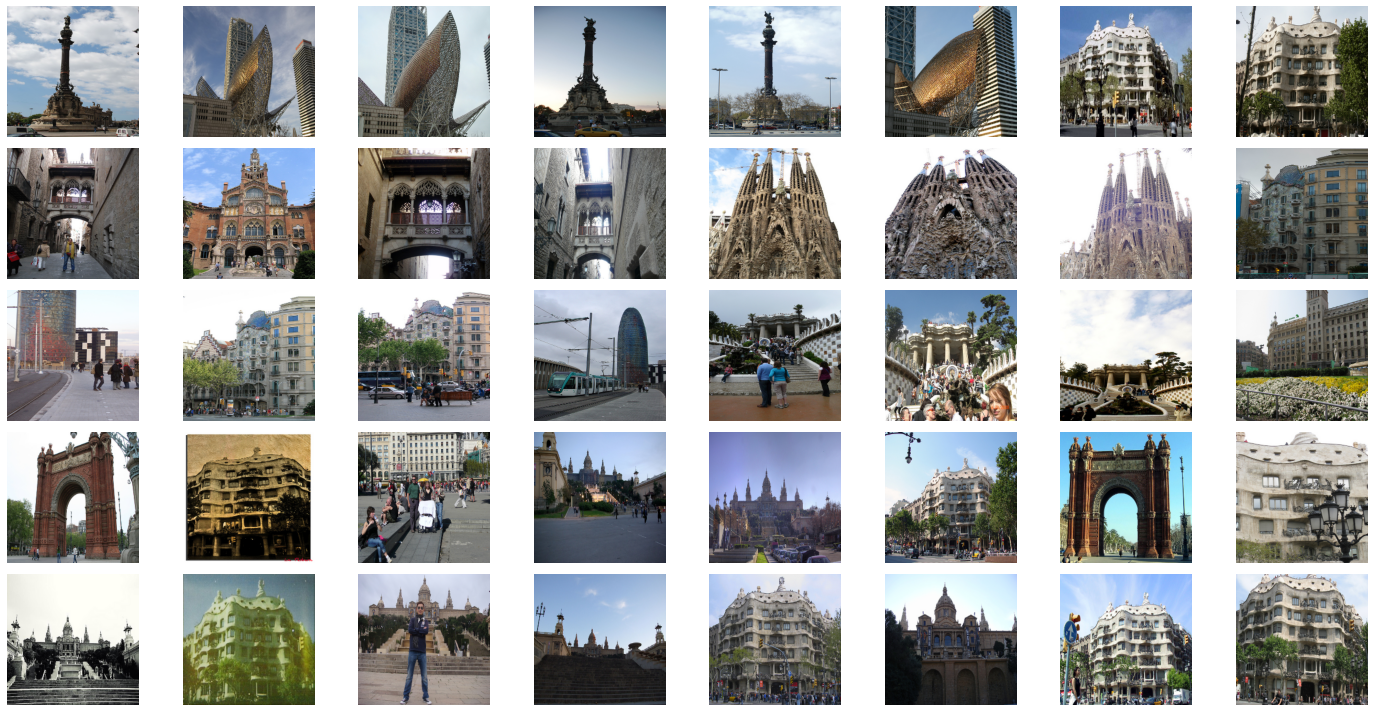

In [6]:
plt.figure(figsize=(20,10))
for i in range(40):
    plt.subplot(5,8,i+1)
    plt.imshow(X[i])
    plt.axis("off")
plt.tight_layout()
plt.show()

### Model
- Vanilla AE: The shape of latent space would be different depending on the data.
- Variational AE: The shape of latent space would be a probability distribution $z \sim N(0,1)$.

**VAE** would be better choise but **AE** is used experimentally here.

#### get model

In [5]:
import importlib
import model

importlib.reload(model)
from model import AE #,VAE,VAE2

In [6]:
ae = AE(img_shape=(256,256,3),latent_dim=128)
model = ae.ae

model.compile(optimizer='adam', loss='mse')

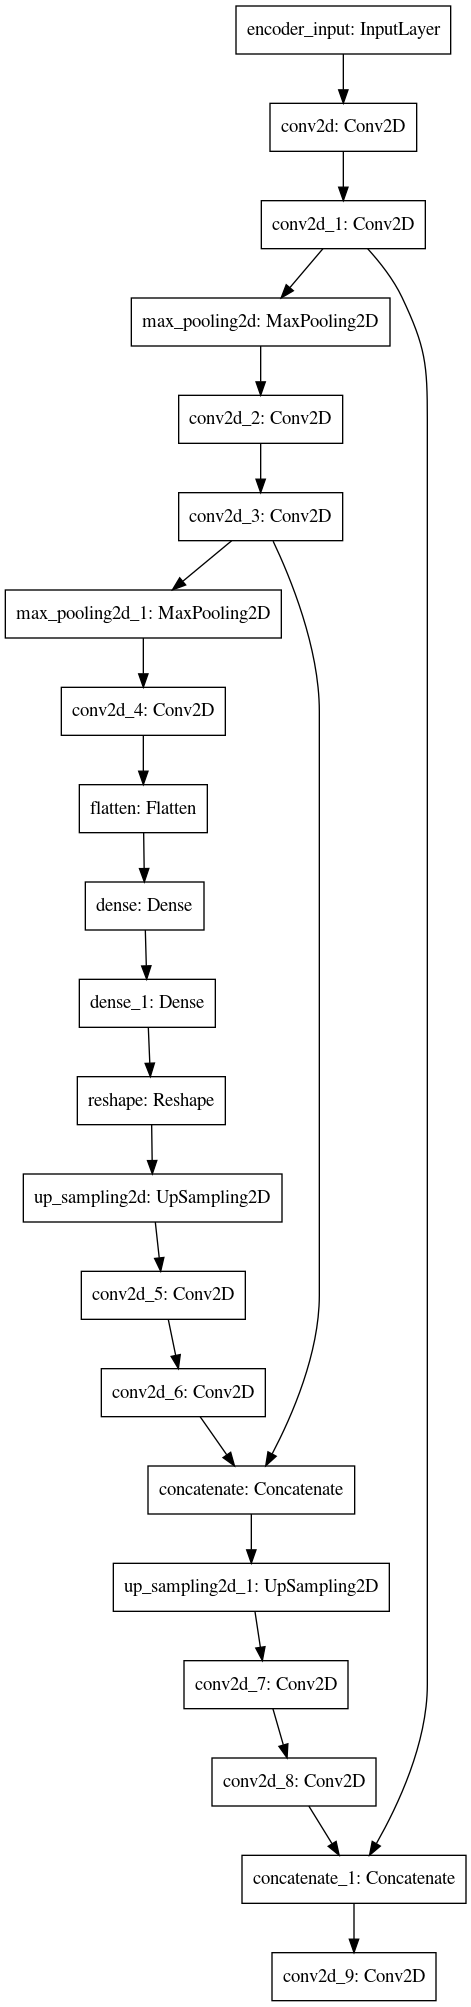

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(model)

# model.summary()

#### train

Get model train from scratch.<br>
**But I prepare trained models below.**

Epoch 1/5
116/116 [==============================] - 25s 212ms/step - loss: 0.7836
Epoch 2/5
116/116 [==============================] - 23s 196ms/step - loss: 0.0514
Epoch 3/5
116/116 [==============================] - 23s 195ms/step - loss: 0.0030
Epoch 4/5
116/116 [==============================] - 22s 194ms/step - loss: 0.0023
Epoch 5/5
116/116 [==============================] - 23s 194ms/step - loss: 0.0020


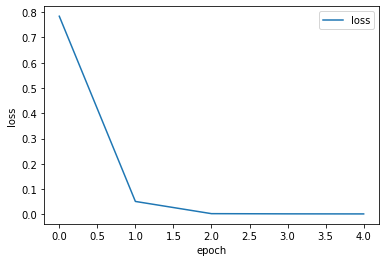

In [7]:
history = model.fit(
    X, X, 
    epochs=5,
    batch_size=8,
    shuffle=True,
    verbose=1)

n_epoch = len(history.history['loss'])
plt.figure()
plt.plot(range(n_epoch), history.history['loss'], label='loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend() 
plt.show()

In [9]:
model.save('ae_model_mse.h5', include_optimizer=True)

encoder = ae.encoder
encoder.save('ae_encoder_mse.h5', include_optimizer=True)

In [ ]:
# Avoid OOM(Out-of-Memory)

import gc
import tensorflow.keras.backend as K

K.clear_session()
gc.collect()

#### get trained model

- ~~`ae_model_mse.h5`: trained whole model with **MSE** loss.~~
- `ae_encoder_mse.h5`: the encoder of trained model with **MSE** loss.


- ~~`ae_model_mae.h5`: trained whole model with **MAE** loss.~~
- `ae_encoder_mae.h5`: the encoder of trained model with **MAE** loss.

In [4]:
from tensorflow.keras.models import load_model

model = load_model("ae_model_mse.h5",compile=False)
encoder = load_model("ae_encoder_mse.h5",compile=False)

#### check model's outputs

In [10]:
pred = model.predict(X)

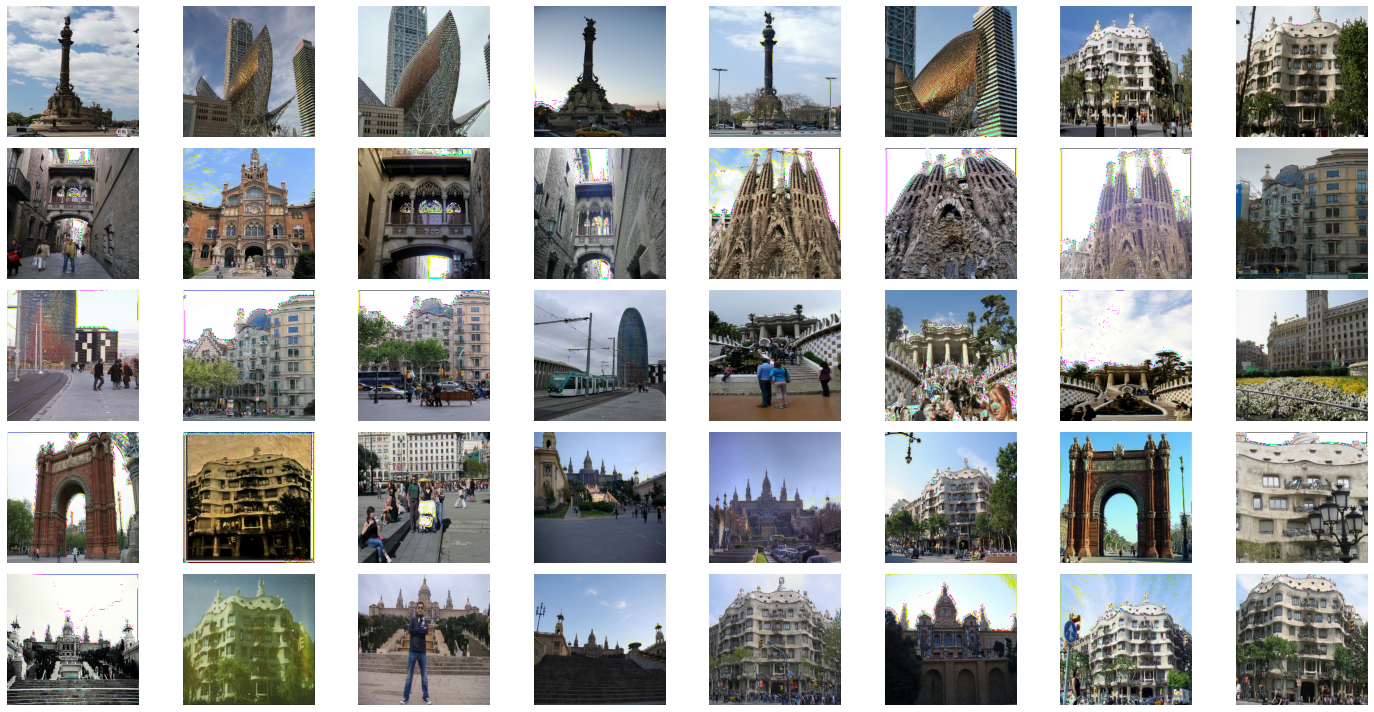

In [19]:
plt.figure(figsize=(20,10))
for i in range(40):
    plt.subplot(5,8,i+1)
    plt.imshow((pred[i] * 255).astype(np.uint8))
    plt.axis("off")
plt.tight_layout()
plt.show()

### Image-Sorting

#### get z score (latent space infos)

In [21]:
z_score = encoder.predict(X)

#### Latent space compression

To see latent space infos, compress it into two dimensions.

**T-sne, PCA, Umap** will be applied. <br>
When dimensionally compressing with Umap, it is said compressing with PCA beforehand is better to get better results.

##### **T-sne**

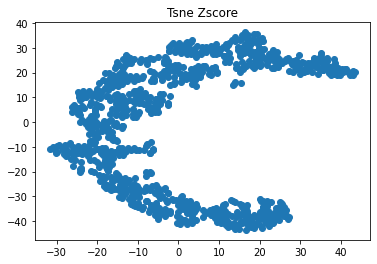

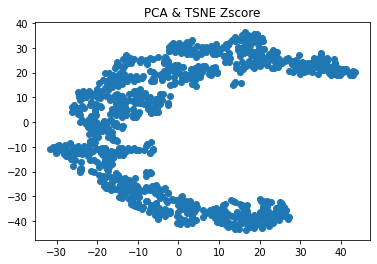

In [22]:
''' TSNE '''
from sklearn.manifold import TSNE
z_score_tsne = TSNE(n_components=2, random_state=0).fit_transform(z_score)
plt.scatter(z_score_tsne[:,0],
            z_score_tsne[:,1])
plt.title("Tsne Zscore")
plt.show()

''' PCA & TSNE '''
from sklearn.decomposition import PCA
pca = PCA(n_components=50, random_state=0)
z_score_pca = pca.fit_transform(z_score)
z_score_pca_tsne = TSNE(n_components=2, random_state=0).fit_transform(z_score)
plt.scatter(z_score_pca_tsne[:,0],
            z_score_pca_tsne[:,1])
plt.title("PCA & TSNE Zscore")
plt.show()

##### **Umap**

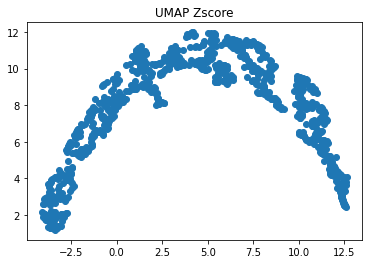

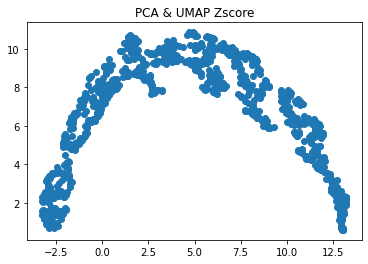

In [23]:
''' UMAP '''
import umap.umap_ as umap

z_score_umap = umap.UMAP(n_components=2).fit_transform(z_score)
plt.scatter(z_score_umap[:,0],
            z_score_umap[:,1])
plt.title("UMAP Zscore")
plt.show()

''' PCA & UMAP '''
# In many t-SNE applications, a value of 50 is recommended, although there’s no guarantee that this is appropriate for all settings.
from sklearn.decomposition import PCA
pca = PCA(n_components=50, random_state=0)
z_score_pca = pca.fit_transform(z_score)
z_score_pca_umap = umap.UMAP(n_components=2).fit_transform(z_score_pca)
plt.scatter(z_score_pca_umap[:,0],
            z_score_pca_umap[:,1])
plt.title("PCA & UMAP Zscore")
plt.show()

#### z_score dictionary

Image-Variables Dictinary $\mathbf{D_{img-z}}$

In [48]:
ref_image_idx = 514 # 756

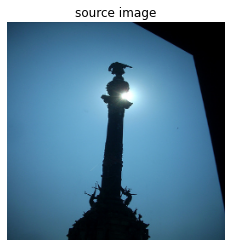

In [49]:
plt.imshow(X[ref_image_idx])
plt.axis("off")
plt.title("source image")
plt.show()

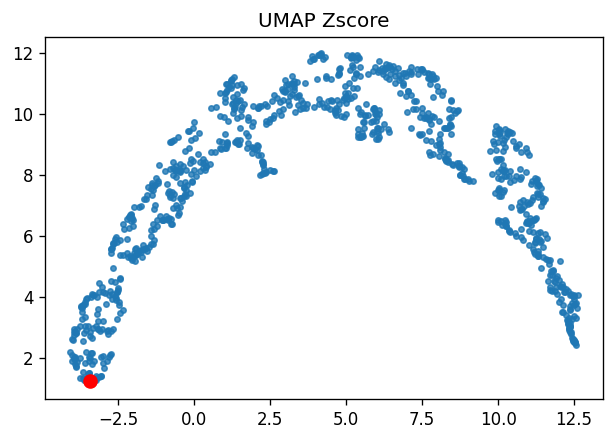

In [50]:
plt.figure(dpi=120)
plt.scatter(z_score_umap[:,0],z_score_umap[:,1],s=10,alpha=.8)
plt.scatter(z_score_umap[ref_image_idx,0],z_score_umap[ref_image_idx,1],s=60,c="red")
plt.title("UMAP Zscore")
plt.show()

#### image-sorting distance calculation method

In [46]:
def square_equation(z_database, z):
    """ Return the index in order of distance to a value from a list
    
    z_database : z scores of all images
    z : z score of reference image    
    """
    assert z.shape[0]==z_database.shape[1], "z dim error"
    
    # Calculate z score distance
    # squared distance
    n_score = np.abs((z_database - z)**2).sum(axis=1)
    sort_idx = np.argsort(n_score)
    
    return sort_idx

In [47]:
from scipy.spatial import distance

def mahalanobis_equation(Z,z):

    cov = np.cov(Z.T)
    cov_i = np.linalg.pinv(cov)

    D_list = []
    for i in range(len(Z)):
        d = distance.mahalanobis(Z[i], z, cov_i)
        D_list.append(d)
    D_list = np.array(D_list)
    
    sort_idx = np.argsort(D_list)
    
    return sort_idx

#### Image-Sorting results

##### square

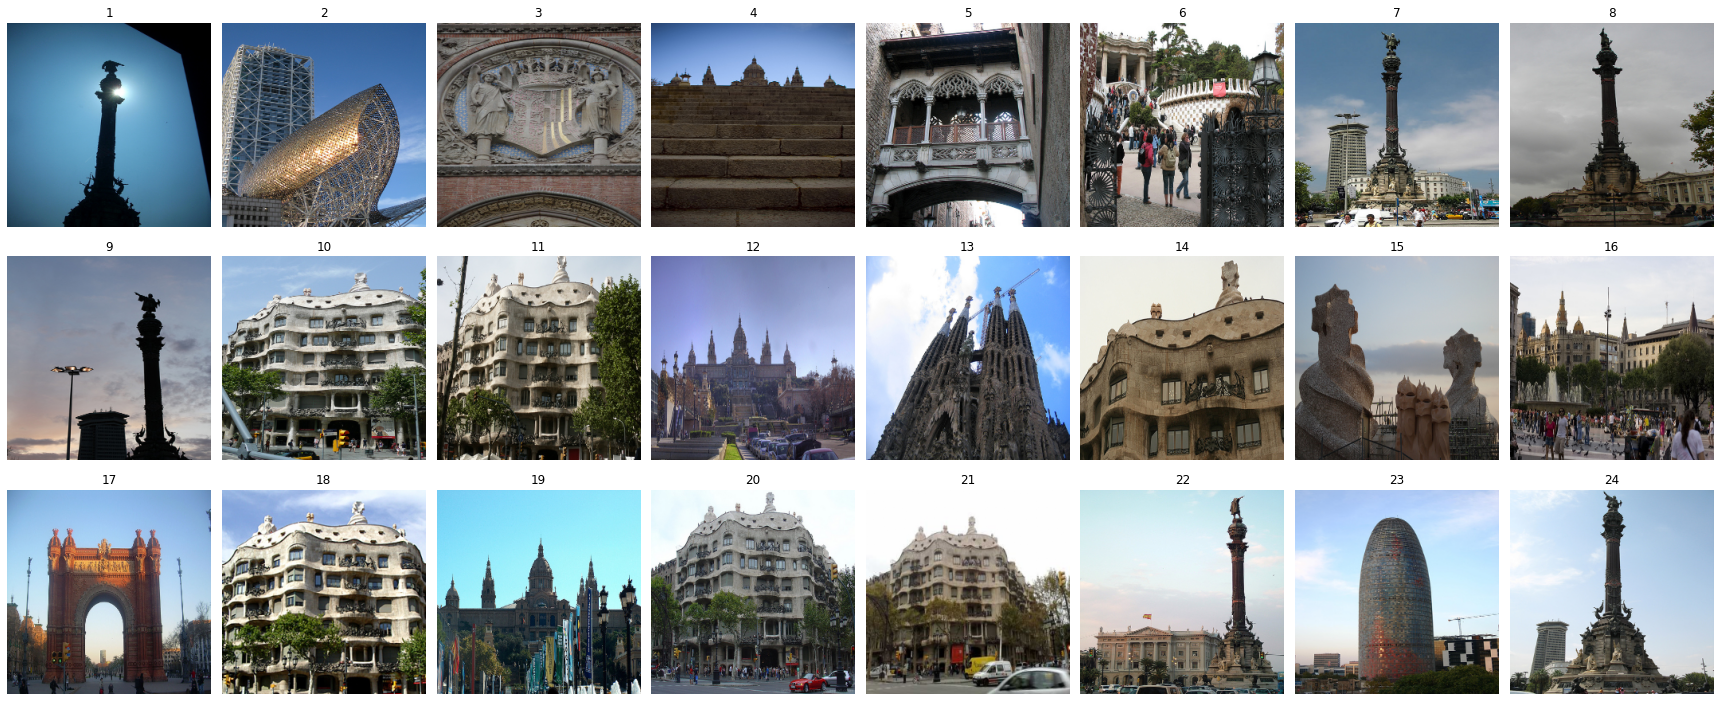

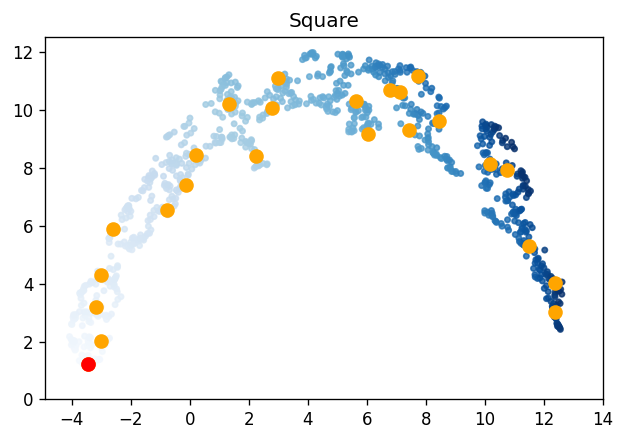

In [71]:
# get image-sort index
sort_idx = square_equation(z_score_umap, z_score_umap[ref_image_idx]) 

# show image-sorting result
n_split = list(range(0,len(sort_idx),math.ceil(len(sort_idx)/24)))# + [len(sort_idx)-1]

plt.figure(figsize=(24,10))
for i in range(24):
    plt.subplot(3,8,i+1)
    plt.imshow(X[sort_idx[n_split[i]]])
    plt.axis("off")
    plt.title(i+1)
plt.tight_layout()
plt.show()

# show z distance result
cm = plt.get_cmap('Blues')  # 'jet'
cm_interval = [ i / (len(z_score) - 1) for i in range(len(z_score)) ]
cm = cm(cm_interval)

plt.figure(dpi=120)
plt.scatter(z_score_umap[sort_idx,0],z_score_umap[sort_idx,1],s=10,alpha=.8,c=cm)
plt.scatter(z_score_umap[sort_idx[n_split],0],z_score_umap[sort_idx[n_split],1],s=60,c="orange")
plt.scatter(z_score_umap[ref_image_idx,0],z_score_umap[ref_image_idx,1],s=60,c="red")
plt.xticks(np.arange(-4, 15+1, 2))
plt.yticks(np.arange(0, 12+1, 2))
plt.title("Square")
plt.show()

##### Mahalanobis

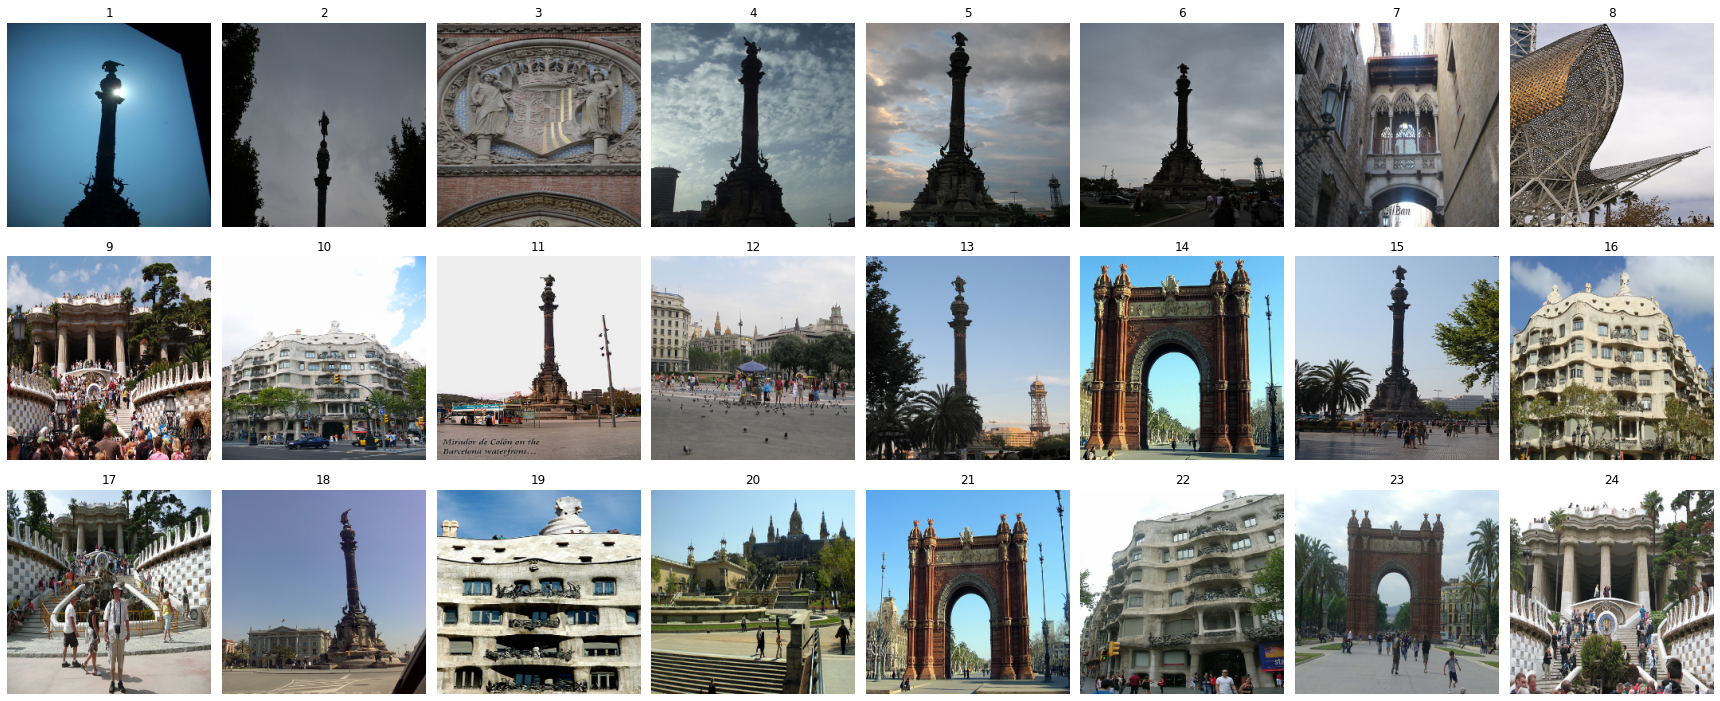

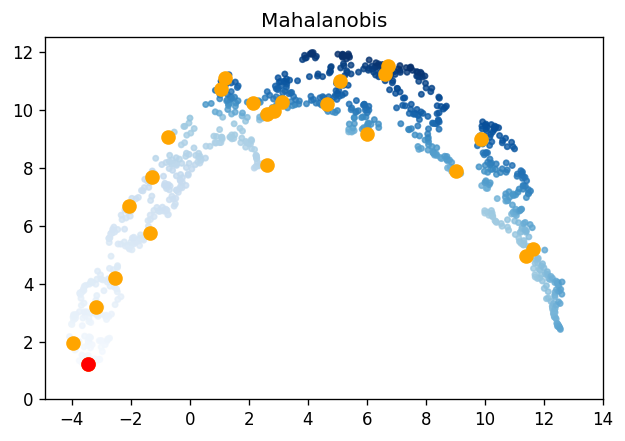

In [72]:
# get image-sort index
sort_idx = mahalanobis_equation(z_score_umap, z_score_umap[ref_image_idx]) 

# show image-sorting result
n_split = list(range(0,len(sort_idx),math.ceil(len(sort_idx)/24)))# + [len(sort_idx)-1]

plt.figure(figsize=(24,10))
for i in range(24):
    plt.subplot(3,8,i+1)
    plt.imshow(X[sort_idx[n_split[i]]])
    plt.axis("off")
    plt.title(i+1)
plt.tight_layout()
plt.show()

# show z distance result
cm = plt.get_cmap('Blues')
cm_interval = [ i / (len(z_score) - 1) for i in range(len(z_score)) ]
cm = cm(cm_interval)

plt.figure(dpi=120)
plt.scatter(z_score_umap[sort_idx,0],z_score_umap[sort_idx,1],s=10,alpha=.8,c=cm)
plt.scatter(z_score_umap[sort_idx[n_split],0],z_score_umap[sort_idx[n_split],1],s=60,c="orange")
plt.scatter(z_score_umap[ref_image_idx,0],z_score_umap[ref_image_idx,1],s=60,c="red")
plt.xticks(np.arange(-4, 15+1, 2))
plt.yticks(np.arange(0, 12+1, 2))
plt.title("Mahalanobis")
plt.show()